In [70]:
import numpy as np
import pandas as pd
from statistics import mean, variance
from tqdm import tqdm

In [71]:
np.ones(4)

array([1., 1., 1., 1.])

In [72]:
dataframe_data_old = pd.read_csv('../../Python/datasets/mturk/mturk_old.csv')
dataframe_data = pd.read_csv('../../Python/datasets/mturk/mturk.csv')
dataframe_data_old

,gender,tutorial,quizScore
0,0,1,0
1,1,1,10
2,1,1,0
3,0,1,0
4,0,1,10
...,...,...,...
1791,1,3,2
1792,0,3,7
1793,1,3,2
1794,0,3,4


In [73]:
dataframe_data

,gender,tutorial,quizScore
0,0,1,0
1,1,1,10
2,1,1,0
3,0,1,0
4,0,1,10
...,...,...,...
2591,1,3,1
2592,1,3,1
2593,1,3,0
2594,0,3,0


In [74]:
dataframe_data["tutorial"].value_counts()

1    999
3    998
2    599
Name: tutorial, dtype: int64

### Exploratory Data Analysis

In [75]:
dataframe_data["gender"].value_counts()

 1    1403
 0    1178
-9      15
Name: gender, dtype: int64

In [76]:
dataframe_data_male = dataframe_data[dataframe_data.gender == 0]
dataframe_data_female = dataframe_data[dataframe_data.gender == 1]
dataframe_data_male

,gender,tutorial,quizScore
0,0,1,0
3,0,1,0
4,0,1,10
5,0,1,8
7,0,1,1
...,...,...,...
2587,0,3,10
2588,0,3,0
2589,0,3,4
2594,0,3,0


In [77]:
dataframe_data_female

,gender,tutorial,quizScore
1,1,1,10
2,1,1,0
6,1,1,0
8,1,1,0
11,1,1,0
...,...,...,...
2586,1,3,0
2590,1,3,0
2591,1,3,1
2592,1,3,1


In [78]:
dataframe_data_male["tutorial"].value_counts()

3    474
1    447
2    257
Name: tutorial, dtype: int64

In [79]:
dataframe_data_female["tutorial"].value_counts()

1    546
3    521
2    336
Name: tutorial, dtype: int64

- Here for males, the distribution of tutorials is given as follows
    - tutorial three is selected with 474/1178 = 0.4023
    - tutorial one is selected with 447/1178 = 0.3795
    - tutorial two is selected with 257/1178 = 0.2182
    
- Here for females, the distribution of tutorials is given as follows
    - tutorial three is selected with 521/1403 = 0.3713
    - tutorial one is selected with 546/1403 =  0.3892
    - tutorial two is selected with 336/1403 =  0.2395


In [80]:
dataframe_data_male_1 = dataframe_data_male[dataframe_data_male.tutorial == 1]
dataframe_data_male_2 = dataframe_data_male[dataframe_data_male.tutorial == 2]
dataframe_data_male_3 = dataframe_data_male[dataframe_data_male.tutorial == 3]
dataframe_data_female_1 = dataframe_data_female[dataframe_data_female.tutorial == 1]
dataframe_data_female_2 = dataframe_data_female[dataframe_data_female.tutorial == 2]
dataframe_data_female_3 = dataframe_data_female[dataframe_data_female.tutorial == 3]
# dataframe_data_male_1 = dataframe_data[dataframe_data.gender == 0 and dataframe_data.tutorial == 2]
# dataframe_data_male_2 = dataframe_data[dataframe_data.gender == 0 and dataframe_data.tutorial == 3]
# dataframe_data_female_0 = dataframe_data[dataframe_data.gender == 1 and dataframe_data.tutorial == 1]
# dataframe_data_female_1 = dataframe_data[dataframe_data.gender == 1 and dataframe_data.tutorial == 2]
# dataframe_data_female_2 = dataframe_data[dataframe_data.gender == 1 and dataframe_data.tutorial == 3]

In [81]:
dataframe_data_male_1

,gender,tutorial,quizScore
0,0,1,0
3,0,1,0
4,0,1,10
5,0,1,8
7,0,1,1
...,...,...,...
992,0,1,10
993,0,1,10
994,0,1,0
996,0,1,0


In [82]:
dataframe_data_male_1["quizScore"].value_counts()

10    137
0     122
1      86
5      24
6      22
9      17
2      16
8       8
4       7
7       4
3       4
Name: quizScore, dtype: int64

<AxesSubplot:>

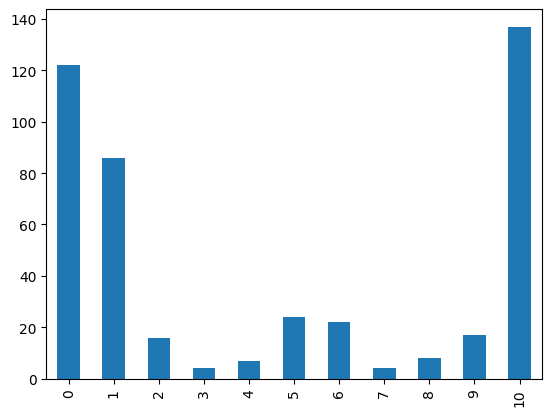

In [116]:
dataframe_data_male_1["quizScore"].value_counts().sort_index().plot.bar()

In [83]:
sum = 137+122+86+24+22+17+16
print(122.0/sum,86/sum,16/sum,24/sum,22/sum,17/sum,137.0/sum)

0.28773584905660377 0.2028301886792453 0.03773584905660377 0.05660377358490566 0.05188679245283019 0.04009433962264151 0.3231132075471698


In [84]:
dataframe_data_male_2["quizScore"].value_counts()

10    111
0      45
1      43
9      22
5      14
2       9
6       6
8       3
7       2
4       1
3       1
Name: quizScore, dtype: int64

<AxesSubplot:>

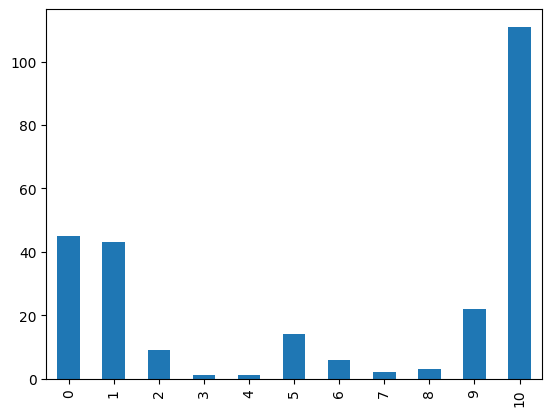

In [117]:
dataframe_data_male_2["quizScore"].value_counts().sort_index().plot.bar()

In [85]:
sum = 111+45+43+22+14
print(str(45/sum)+","+str(43/sum)+","+str(14/sum)+","+str(22/sum)+","+str(111/sum))

0.19148936170212766,0.1829787234042553,0.059574468085106386,0.09361702127659574,0.4723404255319149


In [86]:
dataframe_data_male_3["quizScore"].value_counts()

0     167
1     138
2      64
10     51
9      16
3      10
5       7
4       7
7       5
8       5
6       4
Name: quizScore, dtype: int64

<AxesSubplot:>

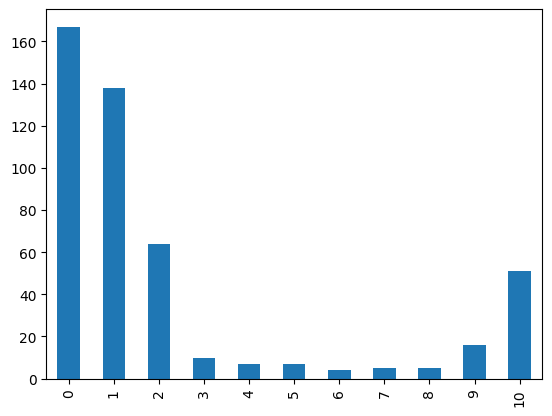

In [118]:
dataframe_data_male_3["quizScore"].value_counts().sort_index().plot.bar()

In [87]:
sum = 167+138+64+51+16+10
print(str(167/sum)+","+str(138/sum)+","+str(64/sum)+","+str(10/sum)+","+str(16/sum)+","+str(51/sum))

0.3744394618834081,0.3094170403587444,0.14349775784753363,0.02242152466367713,0.03587443946188341,0.11434977578475336


In [88]:
dataframe_data_female_1["quizScore"].value_counts()

0     168
10    102
1      98
6      54
5      40
2      29
9      17
3      15
4      11
7       7
8       5
Name: quizScore, dtype: int64

In [89]:
sum = 168+102+98+54+40+29+17+15+11
print(str(168/sum)+","+str(98/sum)+","+str(29/sum)+","+str(15/sum)+","+str(11/sum)+","+str(40/sum)+","+str(54/sum)+","+str(17/sum)+","+str(102/sum))

0.3146067415730337,0.18352059925093633,0.054307116104868915,0.028089887640449437,0.020599250936329586,0.0749063670411985,0.10112359550561797,0.031835205992509365,0.19101123595505617


<AxesSubplot:>

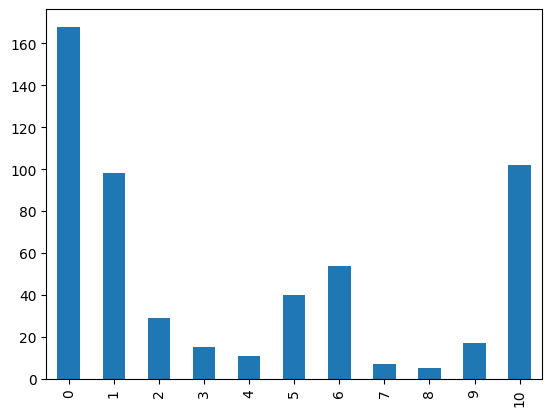

In [119]:
dataframe_data_female_1["quizScore"].value_counts().sort_index().plot.bar()

In [90]:
dataframe_data_female_2["quizScore"].value_counts()

0     289
1      43
2       3
10      1
Name: quizScore, dtype: int64

<AxesSubplot:>

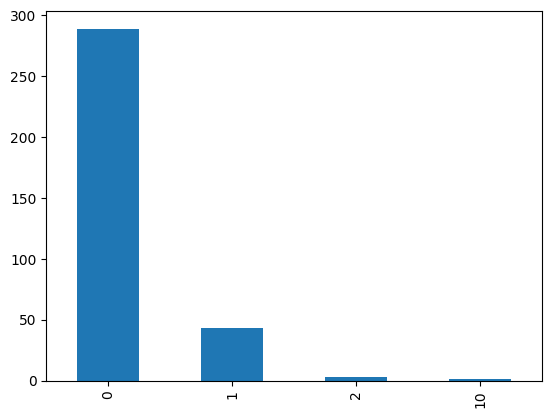

In [120]:
dataframe_data_female_2["quizScore"].value_counts().sort_index().plot.bar()

In [91]:
dataframe_data_female_3["quizScore"].value_counts()

0     213
1     167
2      67
10     32
3      10
5       6
6       6
4       6
9       6
8       5
7       3
Name: quizScore, dtype: int64

<AxesSubplot:>

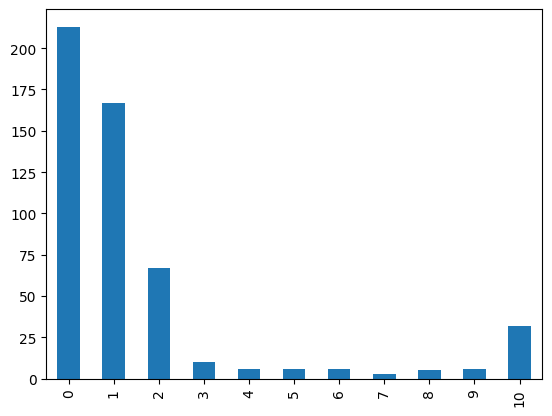

In [121]:
dataframe_data_female_3["quizScore"].value_counts().sort_index().plot.bar()

In [92]:
sum = 213+167+67+32+10
print(str(213/sum)+","+str(167/sum)+","+str(67/sum)+","+str(10/sum)+","+str(32/sum))

0.43558282208588955,0.34151329243353784,0.13701431492842536,0.02044989775051125,0.065439672801636


In [93]:
def argmax(lst):
  return lst.index(max(lst))

In [94]:
rews = [[[0.2729,0.1924,0.0358,0.0089,0.0157,0.0537,0.0492,0.0089,0.0179,0.0381,0.3065],
         [0.1751,0.1673,0.0350,0.0039,0.0039,0.0545,0.0233,0.0078,0.0117,0.0856,0.4319],
         [0.3523,0.2911,0.1350,0.0211,0.0148,0.0148,0.0084,0.0105,0.0105,0.0339,0.1076]],
        [[0.3077,0.1795,0.0531,0.0274,0.0201,0.0733,0.0989,0.0128,0.0092,0.0311,0.1869],
         [0.8601,0.1280,0.0089,0.0030],
         [0.4088,0.3205,0.1286,0.0191,0.0115,0.0115,0.0115,0.0058,0.0096,0.0116,0.0615]]]
rew_list = [[[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10],[0,1,2,3,4,5,6,7,8,9,10]],[[0,1,2,3,4,5,6,7,8,9,10],[0.0,1.0,2.0,10.0],[0,1,2,3,4,5,6,7,8,9,10]]]
def rew(state,act):
    return np.random.choice(rew_list[state][act],1,p=rews[state][act])[0]

In [95]:
x = [0.4088,0.3205,0.1286,0.0191,0.0115,0.0115,0.0115,0.0058,0.0096,0.0116,0.0615]
print(type(x))
s = 0
for i in x:
    s += i
print(s)

<class 'list'>
1.0


In [97]:
# np.random.choice([0,1,2,10],11,[0.8601,0.1280,0.0089,0.0030])/
# rew(1,2)
# print(np.random.choice(rew_list[1][1],11111111,rews[1][1]))
print(rew_list[1][1],rews[1][1],mean(np.random.choice(rew_list[1][1],111111,p=rews[1][1])))
mean(np.random.choice(rew_list[1][1],111111,p=[0.25,0.25,0.15,0.35]))

[0.0, 1.0, 2.0, 10.0] [0.8601, 0.128, 0.0089, 0.003] 0.1757161757161757


4.056016056016056

In [98]:
mean([ 6,  2,  3,  6,  6, 10,  4,  2,  2,  6,  4])

4.636363636363637

### Using random selection of actions

In [99]:
genders = [0,1]

tutorials = [0,1,2]



def monte_carlo_exploring_starts(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1)[0]
        init_act = np.random.choice(len(tutorials),1)[0]
        
        # print(init_state,init_act)
        rtns[init_state][init_act].append(rew(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [100]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:57<00:00, 239.28it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.4824780232834405, 5.924794785127958, 2.3490222276205515], [3.7232681848066465, 0.17966388586627977, 1.6637005398350833]]


In [101]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:54<00:00, 241.38it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.4969204090175205, 5.901648219441771, 2.3410646157572823], [3.697423748889547, 0.17691755414622473, 1.6503234387280092]]


In [102]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:54<00:00, 241.27it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.531107374489551, 5.896949071586364, 2.3722768692293768], [3.7139418737589507, 0.1765656807567956, 1.6199796492488179]]


### Using selection of actions from the whole dataset D_0

In [103]:
genders = [0,1]
tutorials = [0,1,2]
gender_probs = [(1403.0/1403.0+1178.0),(1178.0/1403.0+1178.0)]
tutorial_probs_male = [0.3795,0.2182,0.4023]
tutorial_probs_female = [0.3892,0.2395,0.3713]

def monte_carlo_exploring_starts(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1,gender_probs)[0]
        if init_state == 0:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_male)[0]
        else:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_female)[0]
        
        
        rtns[init_state][init_act].append(rew(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [104]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:54<00:00, 241.52it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.4859476339178475, 5.8850375850137215, 2.3797253976894694], [3.683967358694348, 0.17683328344806945, 1.6752187987051912]]


In [105]:
monte_carlo_exploring_starts(100000)

100%|██████████| 100000/100000 [06:56<00:00, 239.94it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.554778972520908, 5.842496285289747, 2.3418271843487712], [3.767258501354198, 0.17099227426364075, 1.6592175423881133]]


In [106]:
monte_carlo_exploring_starts(100000)

  8%|▊         | 7779/100000 [00:02<00:33, 2766.30it/s] 


KeyboardInterrupt: 

### Using only the tailscores


In [107]:
rews = [[[0.28773584905660377,0.2028301886792453,0.03773584905660377,0.05660377358490566,0.05188679245283019,0.04009433962264151,0.3231132075471698],
         [0.19148936170212766,0.1829787234042553,0.059574468085106386,0.09361702127659574,0.4723404255319149],
         [0.3744394618834081,0.3094170403587444,0.14349775784753363,0.02242152466367713,0.03587443946188341,0.11434977578475336]],
        [[0.3146067415730337,0.18352059925093633,0.054307116104868915,0.028089887640449437,0.020599250936329586,0.0749063670411985,0.10112359550561797,0.031835205992509365,0.19101123595505617],
         [0.8601,0.1280,0.0089,0.0030],
         [0.43558282208588955,0.34151329243353784,0.13701431492842536,0.02044989775051125,0.065439672801636]]]
rew_list = [[[0,1,2,5,6,9,10],[0,1,5,9,10],[0,1,2,3,9,10]],[[0,1,2,3,4,5,6,9,10],[0,1,2,10],[0,1,2,3,10]]]
def rew_a(state,act):
    return np.random.choice(rew_list[state][act],1,p=rews[state][act])[0]

In [108]:
x = [0.19148936170212766,0.1829787234042553,0.059574468085106386,0.09361702127659574,0.4723404255319149]
s = 0
for i in x:
    s += i
s

1.0

### Using random actions

In [109]:
genders = [0,1]

tutorials = [0,1,2]



def monte_carlo_exploring_starts_tailends(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1)[0]
        init_act = np.random.choice(len(tutorials),1)[0]
        
        
        rtns[init_state][init_act].append(rew_a(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [110]:
monte_carlo_exploring_starts_tailends(100000)

100%|██████████| 100000/100000 [06:52<00:00, 242.54it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.417684945524589, 5.992253647991353, 2.1064861951248726], [3.668638346179124, 0.17691800922321374, 1.32403782448955]]


In [ ]:
monte_carlo_exploring_starts_tailends(100000)

100%|██████████| 100000/100000 [06:49<00:00, 244.49it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.7233140194731495, 4.995678790061217, 4.16664656212304], [4.436963263358779, 3.3081454764051696, 3.2296256169495607]]


In [ ]:
monte_carlo_exploring_starts_tailends(100000)

100%|██████████| 100000/100000 [06:50<00:00, 243.32it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.7337842734629785, 5.028698100772871, 4.173310328415041], [4.416063279586249, 3.2369671060444127, 3.166026641065643]]


### Using actual state and policy probabilities (excluding middle scores)

In [111]:
genders = [0,1]
tutorials = [0,1,2]
gender_probs = [(1403.0/1403.0+1178.0),(1178.0/1403.0+1178.0)]
tutorial_probs_male = [0.3795,0.2182,0.4023]
tutorial_probs_female = [0.3892,0.2395,0.3713]

def monte_carlo_exploring_starts_tailend_actual(mc_iters):
    rtns = [[[],[],[]],[[],[],[]]]
    policy = [[0,0,0],[0,0,0]]
    qs = [[0,0,0],[0,0,0]]
    
    for i in tqdm(range(mc_iters)):
        init_state = np.random.choice(len(genders),1,gender_probs)[0]
        if init_state == 0:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_male)[0]
        else:
            init_act = np.random.choice(len(tutorials),1,tutorial_probs_female)[0]
        
        
        rtns[init_state][init_act].append(rew_a(init_state,init_act)*1.0)
        # print(init_state,init_act,rew(init_state,init_act))
        qs[init_state][init_act] = mean(rtns[init_state][init_act])
        for s in genders:
            for j in range(len(policy[s])):
#                 if j != argmax(qs[init_state]):
                policy[s][j] = 0
            policy[s][argmax(qs[s])] = 1
            
    
    print(policy)
    print(qs)
#     print(rtns)

#### Experiment Trials

In [112]:
monte_carlo_exploring_starts_tailend_actual(100000)

100%|██████████| 100000/100000 [06:52<00:00, 242.43it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.435223522352235, 5.973509933774834, 2.157344328911199], [3.640894607106355, 0.17721897025444988, 1.3169836302359172]]


In [ ]:
monte_carlo_exploring_starts_tailend_actual(100000)

100%|██████████| 100000/100000 [06:49<00:00, 244.07it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.750178359096314, 5.0122181022430246, 4.202898550724638], [4.465078309245933, 3.235213857744557, 3.190829642044774]]


In [ ]:
monte_carlo_exploring_starts_tailend_actual(100000)

100%|██████████| 100000/100000 [06:51<00:00, 242.73it/s]

[[0, 1, 0], [1, 0, 0]]
[[4.72998002542219, 5.020049519898545, 4.184292333861223], [4.472870090634441, 3.2403937947494033, 3.1989010325463436]]
